In [34]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors
import pandas as pd

import time

In [31]:
from invisible_cities.core import system_of_units as units

from antea.io.mc_io import load_mchits
from antea.io.mc_io import load_mcsns_response
import antea.database.load_db as db
import utils.histo_functions as hf

In [35]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue = tableau20[0]
green = tableau20[4]
red = tableau20[6]
pink = tableau20[7]
purple = tableau20[8]
light_purple = tableau20[9]
brown = tableau20[10]
grey = tableau20[15]

color_nice = '#029386'

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 8

colors = [blue, green, red, purple, brown, grey]
linestyle = ['-', '-.', ':','-','--', ':']

In [36]:
def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [37]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f mm
        $\sigma$ = %.3f +/- %.3f mm
        FWHM res. = %.3f mm
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

def gtext_angle(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f deg
        $\sigma$ = %.3f +/- %.3f deg
        FWHM res. = %.3f deg
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

In [38]:
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

## Load full MC

In [39]:
file_base = '/data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_{0}_{1}_2_4_4_2.h5'

dfs = []

bunch = 5
for f in range(17000, 17500, bunch):
    filename = file_base.format(f, bunch)
    try:
        df = pd.read_hdf(filename)
        dfs.append(df)
    except:
        print('File {} not found'.format(filename))
        continue
        
df_full_all = pd.concat(dfs)
print(len(df_full_all))

File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17175_5_2_4_4_2.h5 not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17200_5_2_4_4_2.h5 not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17410_5_2_4_4_2.h5 not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17485_5_2_4_4_2.h5 not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17490_5_2_4_4_2.h5 not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_17495_5_2_4_4_2.h5 not found
102965


In [40]:
events = df_full_all.event_id

## Load fast MC

In [8]:
fast_file = '/data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.{}.h5'

#time1 = time.time()

dfs = []
for f in range(17000, 17500):
    filename = fast_file.format(f)
    try:
        df = pd.read_hdf(filename)
        dfs.append(df)
    except:
        print('File {} not found'.format(filename))
        continue
        
#time2 = time.time()
df_fast_all = pd.concat(dfs)

#time3 = time.time()
# select only the events where two interactions have been found
# events where the energy is ok, two true interactions are found, but error matrices haven't given a valid value
df_fast_err = df_fast_all[np.isclose(df_fast_all.not_sel, 3)] 

df_fast_esel = df_fast_all[df_fast_all.true_r1 != 0] 
print(len(df_fast_esel))

#time4 = time.time()

File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17008.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17009.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17028.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17029.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17041.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17042.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17043.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17044.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17094.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17126.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_pc_multi.17127.h5 not found
File /data4/NEXT/users/paolafer/

In [9]:
#print('Time in loop: {0}, in concat: {1}, in sel: {2}'.format(time2-time1, time3-time2, time4-time3))

Time in loop: 210.66572213172913, in concat: 238.5990731716156, in sel: 47.29416275024414


In [10]:
print(len(df_full_all), len(df_fast_all), len(df_fast_esel))

102965 1059712 108130


In [9]:
print(len(df_fast_err))

23654


In [13]:
tot_good = len(df_fast_esel) + len(df_fast_err)
print(f'Fraction error = {len(df_fast_err)/tot_good}')
print(f'Fraction good = {len(df_fast_esel)/tot_good}')

Fraction error = 0.17949068172160504
Fraction good = 0.8205093182783949


In [11]:
### find common events between full and fast MC
events      = df_full_all.event_id
events_fast_esel = df_fast_esel.event_id
common = list(set(events_fast_esel).intersection(events))
print(len(common), len(common)/len(events))
print(len(common), len(common)/len(events_fast_esel))

df_full = df_full_all[df_full_all.event_id.isin(common)]
df_fast = df_fast_esel[df_fast_esel.event_id.isin(common)]

170919 0.8103652638965275
170919 0.7860694000505898


In [12]:
## full_all information
true_r1   = df_full_all.true_r1.values
true_phi1 = df_full_all.true_phi1.values
true_z1   = df_full_all.true_z1.values
true_t1   = df_full_all.true_t1.values

reco_r1   = df_full_all.reco_r1.values
reco_phi1 = df_full_all.reco_phi1.values
reco_z1   = df_full_all.reco_z1.values
true_t2   = df_full_all.true_t2.values

true_r2   = df_full_all.true_r2.values
true_phi2 = df_full_all.true_phi2.values
true_z2   = df_full_all.true_z2.values

reco_r2   = df_full_all.reco_r2.values
reco_phi2 = df_full_all.reco_phi2.values
reco_z2   = df_full_all.reco_z2.values

first_sipm1 = df_full_all.first_sipm1.values
first_sipm2 = df_full_all.first_sipm2.values
sipm_t1 = df_full_all.sipm_t1.values
sipm_t2 = df_full_all.sipm_t2.values

sns_response1 = df_full_all.sns_response1.values
sns_response2 = df_full_all.sns_response2.values

events = df_full_all.event_id.values

true_x1 = true_r1 * np.cos(true_phi1)
reco_x1 = reco_r1 * np.cos(reco_phi1)
true_y1 = true_r1 * np.sin(true_phi1)
reco_y1 = reco_r1 * np.sin(reco_phi1)
true_x2 = true_r2 * np.cos(true_phi2)
reco_x2 = reco_r2 * np.cos(reco_phi2)
true_y2 = true_r2 * np.sin(true_phi2)
reco_y2 = reco_r2 * np.sin(reco_phi2)

### change by hand phi reconstructed as true=~3.14, reco~=-3.14
reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.] = -reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.]
reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.] = -reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.]

diff_x1   = reco_x1 - true_x1
diff_y1   = reco_y1 - true_y1
diff_r1   = reco_r1 - true_r1
diff_phi1 = reco_phi1 - true_phi1
diff_z1   = reco_z1 - true_z1

diff_x2   = reco_x2 - true_x2
diff_y2   = reco_y2 - true_y2
diff_r2   = reco_r2 - true_r2
diff_phi2 = reco_phi2 - true_phi2
diff_z2   = reco_z2 - true_z2

### read sensor positions from database
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')
speed_in_vacuum = 0.299792458# * units.mm / units.ps
ave_speed_in_LXe = 0.210 #* units.mm / units.ps

# distances are saved in mm and times in ps
### Positions
pos_1 = np.array([reco_x1, reco_y1, reco_z1]).transpose()
pos_2 = np.array([reco_x2, reco_y2, reco_z2]).transpose()
sipm_pos_1 = np.array([DataSiPM_idx.loc[first_sipm1].X, DataSiPM_idx.loc[first_sipm1].Y, DataSiPM_idx.loc[first_sipm1].Z]).transpose()
sipm_pos_2 = np.array([DataSiPM_idx.loc[first_sipm2].X, DataSiPM_idx.loc[first_sipm2].Y, DataSiPM_idx.loc[first_sipm2].Z]).transpose()

### Distance of the interaction point from the SiPM seeing the first photon
dist1 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1), axis=1)
dist2 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2), axis=1)

reco_t1 = sipm_t1 - (dist1/ave_speed_in_LXe)
reco_t2 = sipm_t2 - (dist2/ave_speed_in_LXe)


In [13]:
## fast_esel information
true_r1_fast_esel   = df_fast_esel.true_r1.values
true_phi1_fast_esel = df_fast_esel.true_phi1.values
true_z1_fast_esel   = df_fast_esel.true_z1.values
true_t1_fast_esel   = df_fast_esel.true_t1.values

reco_r1_fast_esel   = df_fast_esel.reco_r1.values
reco_phi1_fast_esel = df_fast_esel.reco_phi1.values
reco_z1_fast_esel   = df_fast_esel.reco_z1.values
reco_t1_fast_esel   = df_fast_esel.reco_t1.values

true_r2_fast_esel   = df_fast_esel.true_r2.values
true_phi2_fast_esel = df_fast_esel.true_phi2.values
true_z2_fast_esel   = df_fast_esel.true_z2.values
true_t2_fast_esel   = df_fast_esel.true_t2.values

reco_r2_fast_esel   = df_fast_esel.reco_r2.values
reco_phi2_fast_esel = df_fast_esel.reco_phi2.values
reco_z2_fast_esel   = df_fast_esel.reco_z2.values
reco_t2_fast_esel   = df_fast_esel.reco_t2.values

events_fast_esel     = df_fast_esel.event_id.values
phot_like1_fast_esel = df_fast_esel.phot_like1.values
phot_like2_fast_esel = df_fast_esel.phot_like2.values

In [33]:
print(len(sipm_t1), len(reco_r1), len(true_t1))

210916 210916 210916


In [34]:
len(true_t1_fast_esel)

217435

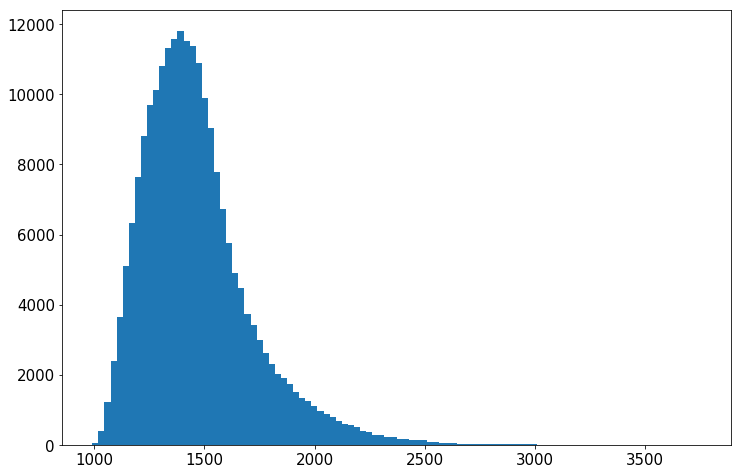

In [35]:
h=plt.hist(true_t1_fast_esel, bins=100);

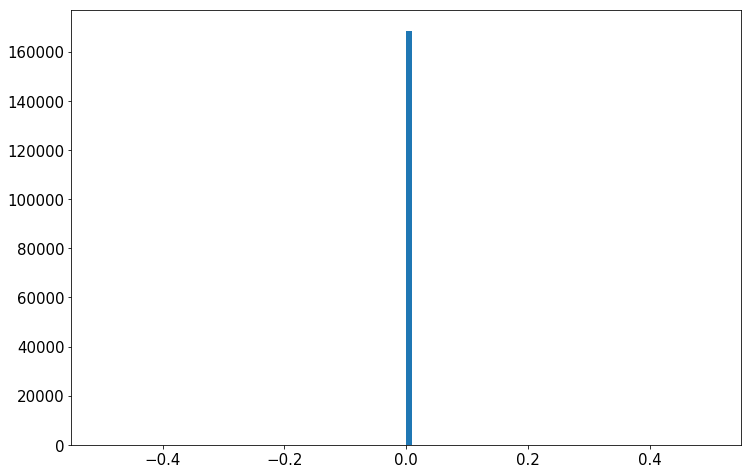

In [15]:
h = plt.hist(true_t2 - true_t2_fast, bins=100);
#plt.xlim(1000, 3000)
#plt.ylim(0, 300)

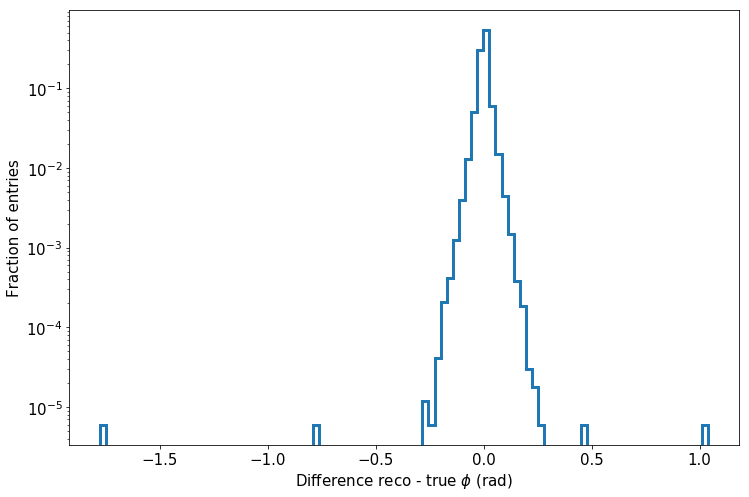

In [23]:
bins = 100
weights = get_weights(reco_phi1 - reco_phi1_fast, True)
h0 = plt.hist(reco_phi1 - reco_phi1_fast, bins=bins, color=colors[0], histtype='step', weights=weights,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
plt.xlabel('Difference reco - true $\phi$ (rad)')
plt.ylabel('Fraction of entries');
plt.yscale('log')

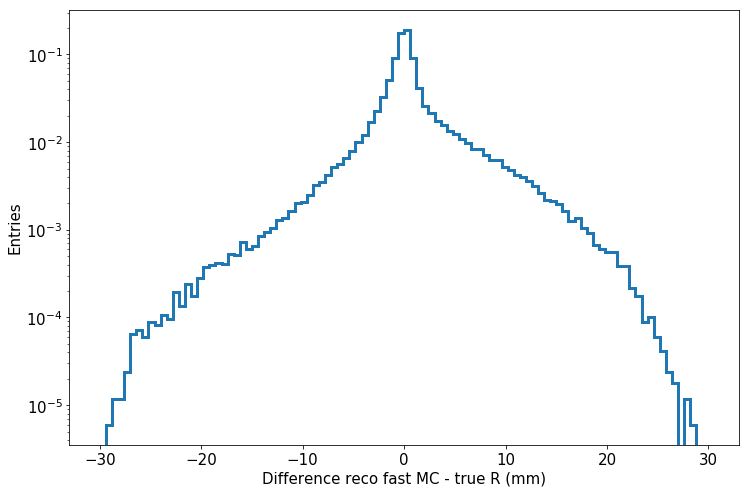

In [17]:
bins = 100
weights = get_weights(reco_r1_fast - true_r1_fast, True)
h0 = plt.hist(reco_r1_fast - true_r1_fast, bins=bins, color=colors[0], range=(-30, 30), histtype='step', weights=weights,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
plt.xlabel('Difference reco fast MC - true R (mm)')
plt.ylabel('Entries');
plt.yscale('log')

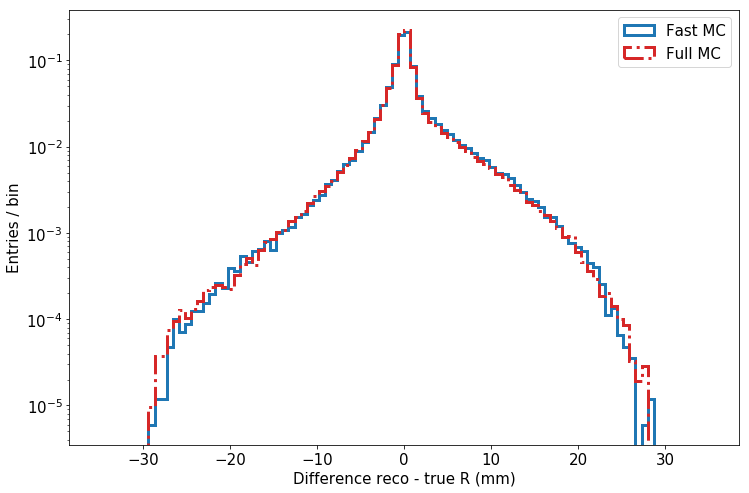

In [33]:
bins = 100
full = reco_r1 - true_r1
fast = reco_r1_fast - true_r1_fast

bins = np.histogram(np.hstack((full, fast)),
                    bins=100, range=(-35, 35))[1] #get the bin edges

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], range=(-30, 30), histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], range=(-30, 30), histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true R (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

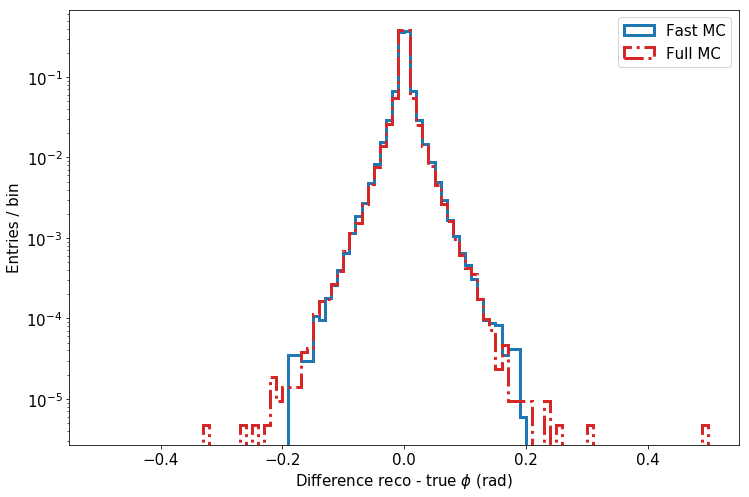

In [34]:
bins = 100
full = reco_phi1 - true_phi1
fast = reco_phi1_fast - true_phi1_fast

bins = np.histogram(np.hstack((full, fast)),
                    range=(-0.5, 0.5), bins=100)[1] #get the bin edges #  range=(-0.2, 0.2)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0],  histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true $\phi$ (rad)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)
#plt.xlim(-7, -5)

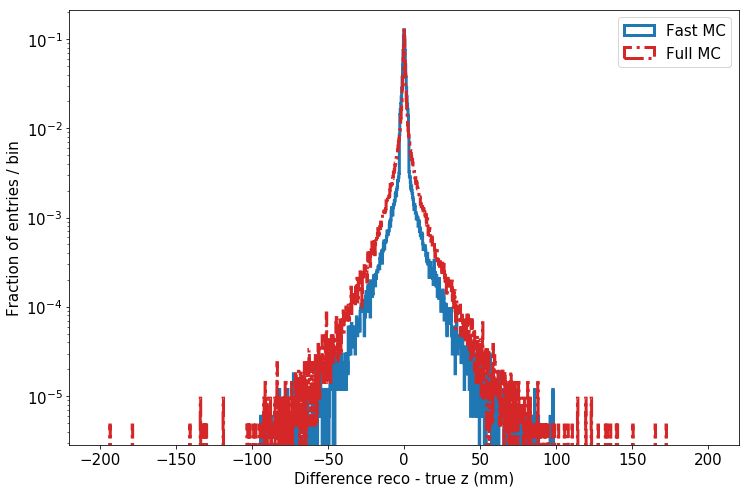

In [48]:
bins = 100
full = reco_z1 - true_z1
fast = reco_z1_fast - true_z1_fast

bins = np.histogram(np.hstack((full, fast)),
                    range=(-200, 200), bins=1333)[1] #get the bin edges #  range=(-0.2, 0.2)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

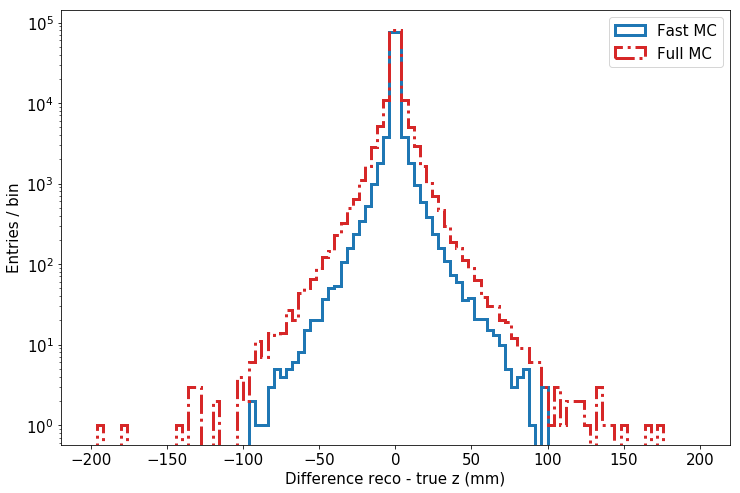

In [28]:
bins = 100
full = reco_z1 - true_z1
fast = reco_z1_fast - true_z1_fast

bins = np.histogram(np.hstack((full, fast)),
                    range=(-200, 200), bins=100)[1] #get the bin edges #  range=(-0.2, 0.2)


h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step',
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step',
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

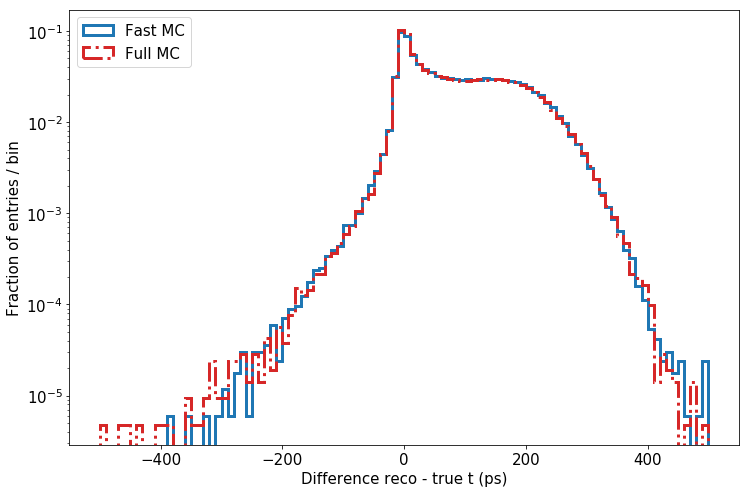

In [29]:
bins = 100
full = reco_t1 - true_t1
fast = reco_t1_fast - true_t1_fast

bins = np.histogram(np.hstack((full, fast)),
                    range=(-500, 500), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

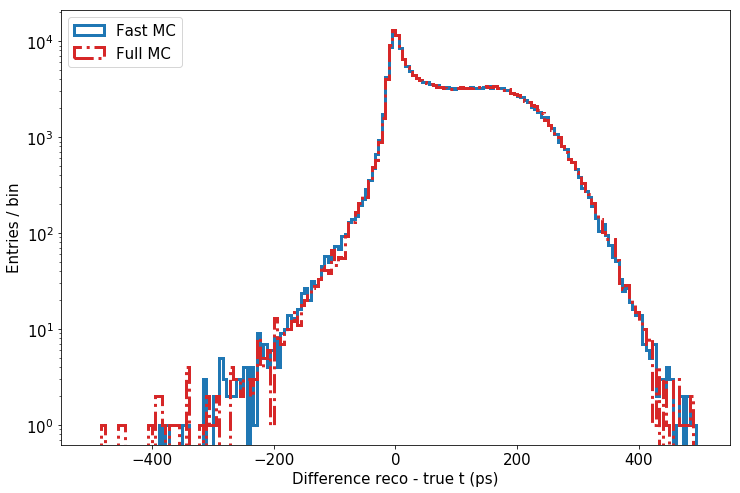

In [28]:
bins = 100
full = reco_t2 - true_t2
fast = reco_t2_fast - true_t2_fast

bins = np.histogram(np.hstack((full, fast)),
                    range=(-500, 500), bins=180)[1] #get the bin edges # range=(-150, 150)

h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step',
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step',
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

In [36]:
phot1_df = df_fast_esel[df_fast_esel.phot_like1>0]
phot2_df = df_fast_esel[df_fast_esel.phot_like2>0]

## fast_esel information
true_r1_phot_fast_esel   = phot1_df.true_r1.values
true_phi1_phot_fast_esel = phot1_df.true_phi1.values
true_z1_phot_fast_esel   = phot1_df.true_z1.values
true_t1_phot_fast_esel   = phot1_df.true_t1.values

reco_r1_phot_fast_esel   = phot1_df.reco_r1.values
reco_phi1_phot_fast_esel = phot1_df.reco_phi1.values
reco_z1_phot_fast_esel   = phot1_df.reco_z1.values
reco_t1_phot_fast_esel   = phot1_df.reco_t1.values

true_r2_phot_fast_esel   = phot2_df.true_r2.values
true_phi2_phot_fast_esel = phot2_df.true_phi2.values
true_z2_phot_fast_esel   = phot2_df.true_z2.values
true_t2_phot_fast_esel   = phot2_df.true_t2.values

reco_r2_phot_fast_esel   = phot2_df.reco_r2.values
reco_phi2_phot_fast_esel = phot2_df.reco_phi2.values
reco_z2_phot_fast_esel   = phot2_df.reco_z2.values
reco_t2_phot_fast_esel   = phot2_df.reco_t2.values



In [37]:
compt1_df = df_fast_esel[df_fast_esel.phot_like1==0]
compt2_df = df_fast_esel[df_fast_esel.phot_like2==0]

## fast_esel information
true_r1_compt_fast_esel   = compt1_df.true_r1.values
true_phi1_compt_fast_esel = compt1_df.true_phi1.values
true_z1_compt_fast_esel   = compt1_df.true_z1.values
true_t1_compt_fast_esel   = compt1_df.true_t1.values

reco_r1_compt_fast_esel   = compt1_df.reco_r1.values
reco_phi1_compt_fast_esel = compt1_df.reco_phi1.values
reco_z1_compt_fast_esel   = compt1_df.reco_z1.values
reco_t1_compt_fast_esel   = compt1_df.reco_t1.values

true_r2_compt_fast_esel   = compt2_df.true_r2.values
true_phi2_compt_fast_esel = compt2_df.true_phi2.values
true_z2_compt_fast_esel   = compt2_df.true_z2.values
true_t2_compt_fast_esel   = compt2_df.true_t2.values

reco_r2_compt_fast_esel   = compt2_df.reco_r2.values
reco_phi2_compt_fast_esel = compt2_df.reco_phi2.values
reco_z2_compt_fast_esel   = compt2_df.reco_z2.values
reco_t2_compt_fast_esel   = compt2_df.reco_t2.values

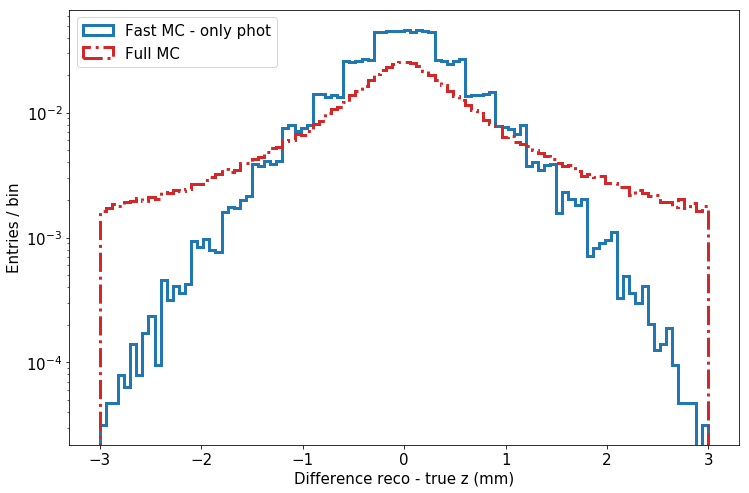

In [46]:
bins = 100
full = reco_z2 - true_z2
fast = reco_z2_phot_fast_esel - true_z2_phot_fast_esel

bins = np.histogram(np.hstack((full, fast)),
                    range=(-3, 3), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)

h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC - only phot')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

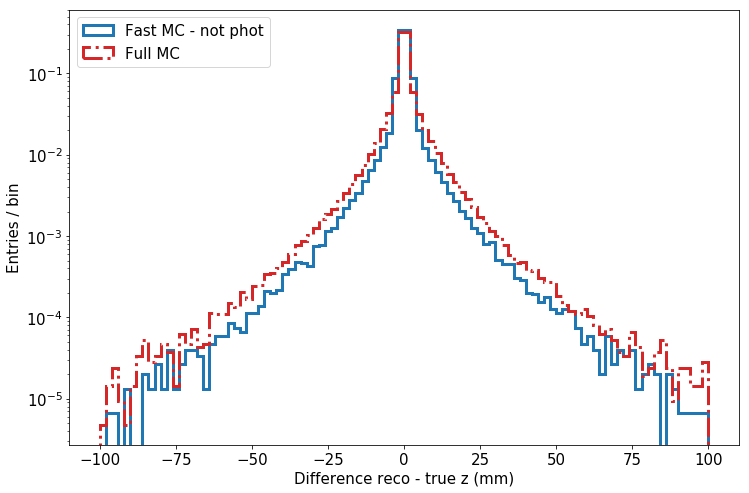

In [47]:
bins = 100
full = reco_z2 - true_z2
fast = reco_z2_compt_fast_esel - true_z2_compt_fast_esel

bins = np.histogram(np.hstack((full, fast)),
                    range=(-100, 100), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)

h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC - not phot')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

## Plot error matrices

In [20]:
err_folder = '/data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/tables/error_matrices/'
#err_r_file   = err_folder + 'errmat_r.npz'
#err_phi_file = err_folder + 'errmat_phi.npz'
err_z_file   = err_folder + 'errmat_z_compt_like.npz'
err_t_file   = err_folder + 'errmat_t_compt_like.npz'

t_mtrx = np.load(err_t_file)
z_mtrx = np.load(err_z_file)

print(list(t_mtrx.keys()))


['errmat', 'eff', 'xmin', 'ymin', 'dx', 'dy']


In [17]:
print(t_mtrx['xmin'], t_mtrx['ymin'], t_mtrx['dx'], t_mtrx['dy'])

1000.0 -500.0 5.0 5.0


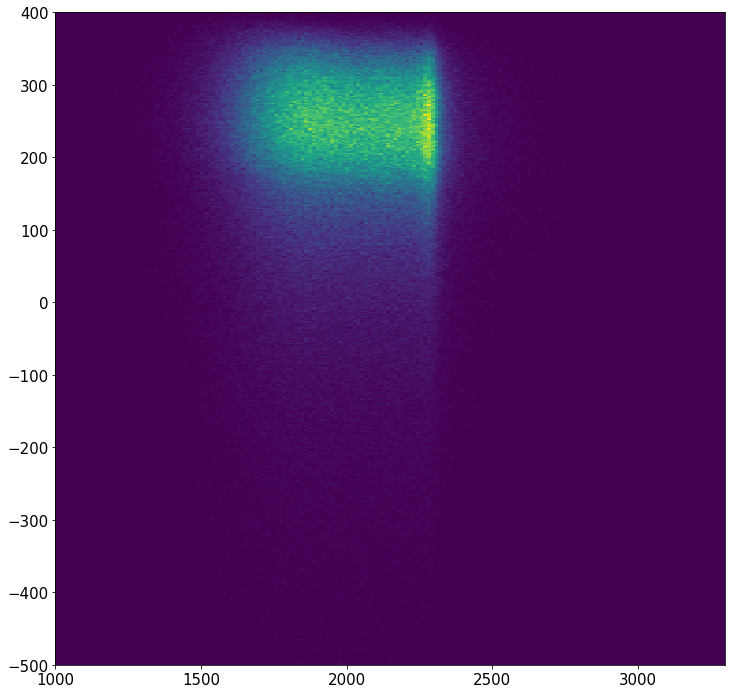

In [19]:

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 12

m = t_mtrx['errmat']
extents = (t_mtrx['xmin'], t_mtrx['xmin']+len(t_mtrx['errmat'])*t_mtrx['dx'], \
           t_mtrx['ymin'], t_mtrx['ymin']+len(t_mtrx['errmat'][0])*t_mtrx['dy'])
#print(extents)
plt.imshow(m, extent=extents, aspect='auto')
plt.show()

(array(-958.), 957.9999999999854, array(-100.), 100.00000000000284)


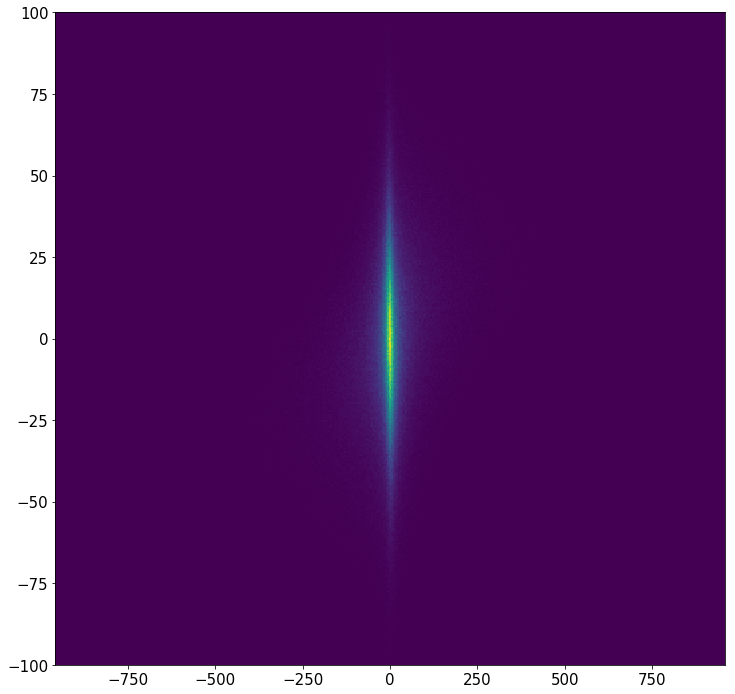

In [21]:
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 12

m = z_mtrx['errmat']
extents = (z_mtrx['xmin'], z_mtrx['xmin']+len(z_mtrx['errmat'])*z_mtrx['dx'], \
           z_mtrx['ymin'], z_mtrx['ymin']+len(z_mtrx['errmat'][0])*z_mtrx['dy'])
print(extents)
plt.imshow(m, extent=extents, aspect='auto')
plt.show()

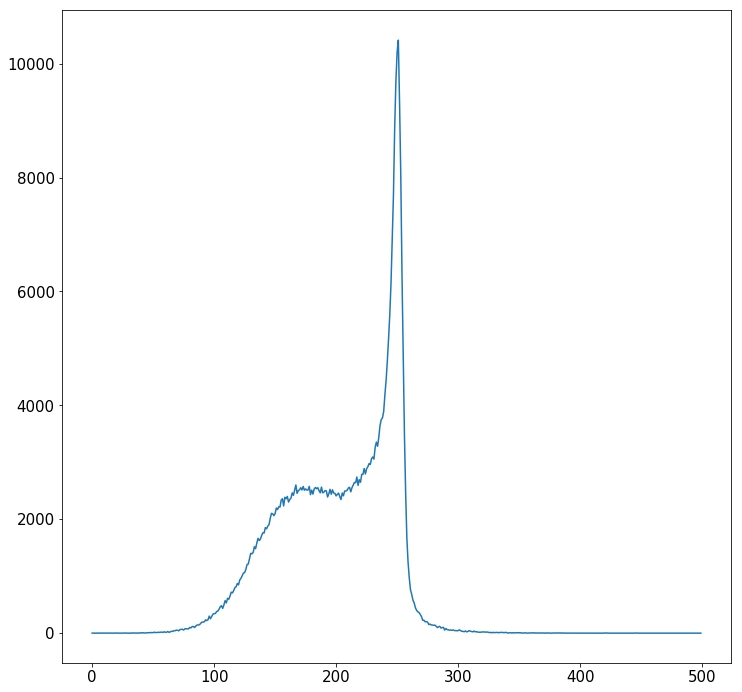

In [25]:
plt.plot(np.sum(m,axis=0))

## Check what happens really in the coincidences

In [24]:
folder = '/data4/NEXT/users/paolafer/SimMC/pet/'
file_full = folder + 'full_body_phantom.{0:03d}.pet.h5'

# events = event IDs of the coincidences found with our reconstruction algorithm

c_energies, nc_energies = [], []

for ifile in range(17000, 17050):

    file_name = file_full.format(ifile)
    try:
        hits = load_mchits(file_name)
    except:
        print('File {} not found'.format(file_name))
        
    c_hits = hits[hits.event_id.isin(events)]
    for evt in c_hits.event_id.unique():
        evt_hits = c_hits[c_hits.event_id == evt]
        energy   = evt_hits.energy.sum()
        c_energies.append(energy)
        
    nc_hits = hits[~hits.event_id.isin(events)]
    for evt in nc_hits.event_id.unique():
        evt_hits = nc_hits[nc_hits.event_id == evt]
        energy   = evt_hits.energy.sum()
        nc_energies.append(energy)
        
c_energies  = np.array(c_energies)
nc_energies = np.array(nc_energies)

File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17008.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17009.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17028.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17029.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17041.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17042.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17043.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17044.pet.h5 not found


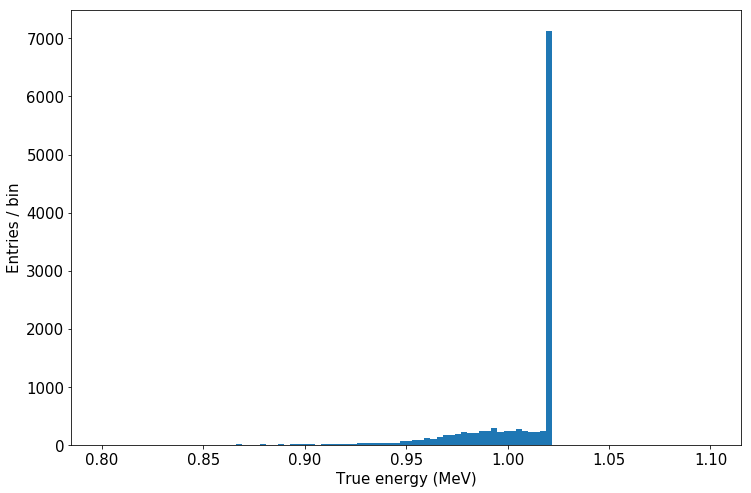

In [25]:
h = plt.hist(c_energies, bins=100, range=(0.8, 1.1))
plt.xlabel('True energy (MeV)')
plt.ylabel('Entries / bin');

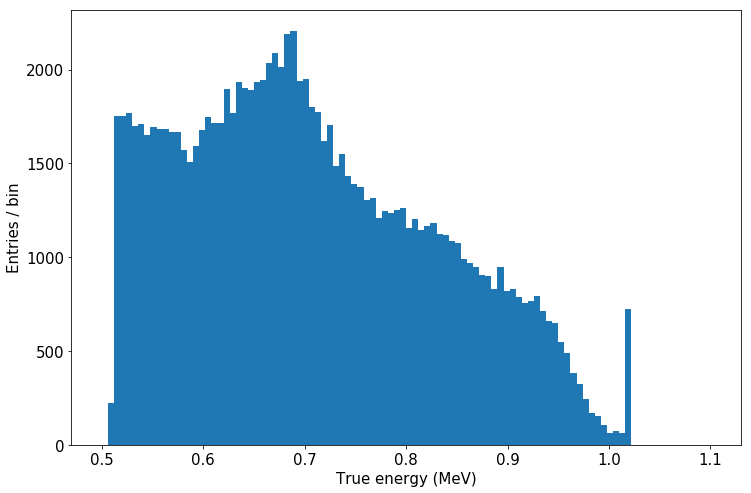

In [26]:
h = plt.hist(nc_energies, bins=100, range=(0.5, 1.1))
plt.xlabel('True energy (MeV)')
plt.ylabel('Entries / bin');

In [27]:
print(len(c_energies[c_energies<0.95])/len(c_energies))
print(len(nc_energies[nc_energies<0.95])/len(nc_energies))

0.04029029029029029
0.9689877987817297


In [29]:
tot_e = c_energies[np.isclose(c_energies, 1.0219982)]
print('Fraction of events that deposit all energy (true) of the coincidences we have selected: {}'.format(len(tot_e)/len(c_energies)))

Fraction of events that deposit all energy (true) of the coincidences we have selected: 0.5785785785785785


In [30]:
part_e = nc_energies[np.isclose(nc_energies, 1.0219982)]
print('Fraction of events that deposit all energy (true) of the events not selected by our reco code: {}'.format(len(part_e)/len(nc_energies)))

Fraction of events that deposit all energy (true) of the events not selected by our reco code: 0.006295013978633982


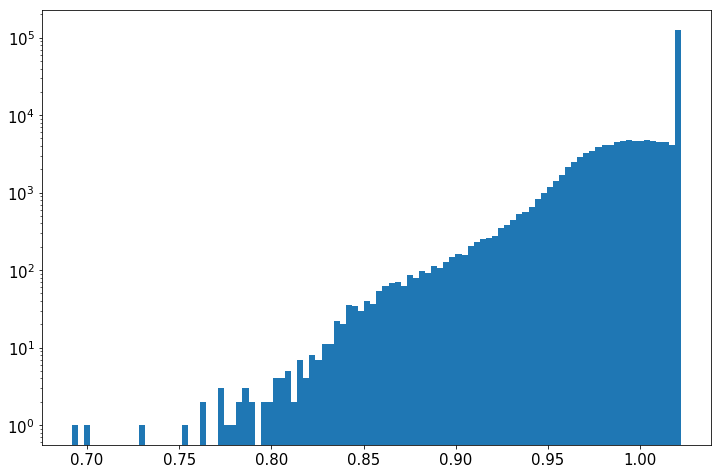

In [35]:
h = plt.hist(df_full_all.hit_energy1 + df_full_all.hit_energy2, bins=100)
plt.yscale('log')

In [ ]:
#let's simulate fastMC for all energies starting from 0.75 MeV and take only tyhe eventID in commin with full.
# The coordinate and time distributions should be exactly the same.

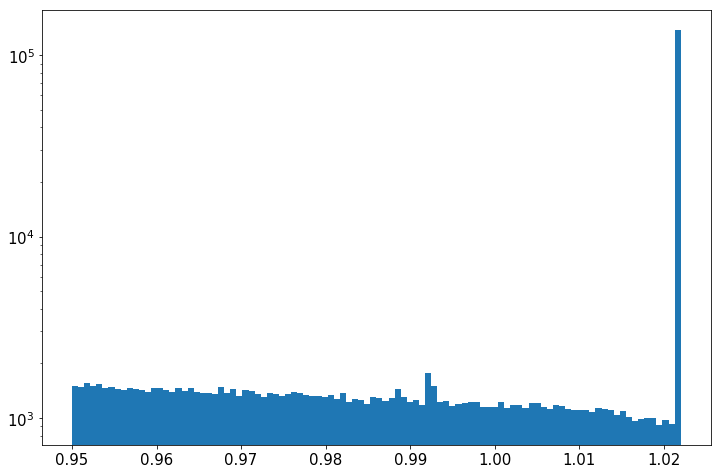

In [36]:
h = plt.hist(df_fast_esel.true_energy, bins=100)#, range=(0.5, 1.1))
plt.yscale('log')

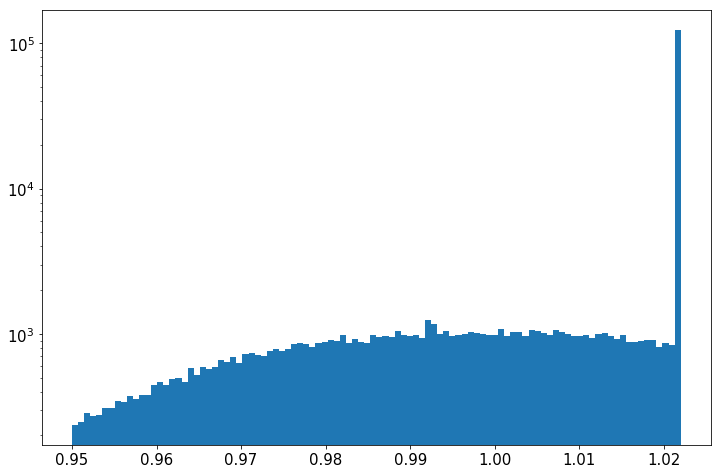

In [29]:
h = plt.hist(df_full.hit_energy1 + df_full.hit_energy2, bins=100)
plt.yscale('log')

In [ ]:
true_r1_fast, true_phi1_fast, true_z1_fast, true_t1_fast = [], [], [], []
reco_r1_fast, reco_phi1_fast, reco_z1_fast, reco_t1_fast = [], [], [], []
true_r2_fast, true_phi2_fast, true_z2_fast, true_t2_fast = [], [], [], []
reco_r2_fast, reco_phi2_fast, reco_z2_fast, reco_t2_fast = [], [], [], []
events_fast, true_energy_fast = [], []

fast_file = '/data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom_test.{}.h5'

dfs = []
for f in range(17000, 18000):
    filename = fast_file.format(f)
    try:
        df = pd.read_hdf(filename)
        dfs.append(df)
    except:
        print('File {} not found'.format(filename))
        continue 
    
    try:
        true_r1_fast   = np.concatenate((true_r1_fast, df['true_r1']))
    except:
        print('No content in file')
        continue
    true_phi1_fast = np.concatenate((true_phi1_fast, df['true_phi1']))
    true_z1_fast   = np.concatenate((true_z1_fast,   df['true_z1']))
    true_t1_fast   = np.concatenate((true_t1_fast,   df['true_t1']))
    
    true_r2_fast   = np.concatenate((true_r2_fast,   df['true_r2']))
    true_phi2_fast = np.concatenate((true_phi2_fast, df['true_phi2']))
    true_z2_fast   = np.concatenate((true_z2_fast,   df['true_z2']))
    true_t2_fast   = np.concatenate((true_t2_fast,   df['true_t2']))
    
    reco_r1_fast   = np.concatenate((reco_r1_fast,   df['reco_r1']))
    reco_phi1_fast = np.concatenate((reco_phi1_fast, df['reco_phi1']))
    reco_z1_fast   = np.concatenate((reco_z1_fast,   df['reco_z1']))
    reco_t1_fast   = np.concatenate((reco_t1_fast,   df['reco_t1']))
    
    reco_r2_fast   = np.concatenate((reco_r2_fast,   df['reco_r2']))
    reco_phi2_fast = np.concatenate((reco_phi2_fast, df['reco_phi2']))
    reco_z2_fast   = np.concatenate((reco_z2_fast,   df['reco_z2']))
    reco_t2_fast   = np.concatenate((reco_t2_fast,   df['reco_t2']))
    
    events_fast      = np.concatenate((events_fast,   df['event_id']))
    true_energy_fast = np.concatenate((true_energy_fast, df['true_energy']))
    
    
coincidences = (true_r1_fast>0) & (true_r2_fast>0) & (true_energy_fast > 0.95)
true_r1_fast   = true_r1_fast[coincidences]
true_phi1_fast = true_phi1_fast[coincidences]
true_z1_fast   = true_z1_fast[coincidences]
true_t1_fast   = true_t1_fast[coincidences]
true_r2_fast   = true_r2_fast[coincidences]
true_phi2_fast = true_phi2_fast[coincidences]
true_z2_fast   = true_z2_fast[coincidences]
true_t2_fast   = true_t2_fast[coincidences]

reco_r1_fast   = reco_r1_fast[coincidences]
reco_phi1_fast = reco_phi1_fast[coincidences]
reco_z1_fast   = reco_z1_fast[coincidences]
reco_t1_fast   = reco_t1_fast[coincidences]
reco_r2_fast   = reco_r2_fast[coincidences]
reco_phi2_fast = reco_phi2_fast[coincidences]
reco_z2_fast   = reco_z2_fast[coincidences]
reco_t2_fast   = reco_t2_fast[coincidences]

events_fast    = events_fast[coincidences]

In [ ]:
evt_sel      = [i in common for i in events]
evt_sel_fast = [i in common for i in events_fast]
evt_sel      = np.array(evt_sel)
evt_sel_fast = np.array(evt_sel_fast)

In [39]:
(len(df_full_all[df_full_all.photo1 == True]) + len(df_full_all[df_full_all.photo2 == True]))/2/len(df_full_all)

0.05415900168787574

In [40]:
(len(df_full_all[df_full_all.photo_like1 == True]) + len(df_full_all[df_full_all.photo_like2 == True]))/2/len(df_full_all)

0.3306837793244704

In [22]:
len(df_full_all[(df_full_all.photo_like1 == True) & (df_full_all.photo_like2 == True)])/len(df_full_all)

0.10943693223842667

0.10943693223842667

In [7]:
import numpy as np

In [2]:
import antea.database.load_db as db

DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

In [19]:
sipms_idx = DataSiPM_idx.loc[np.array([1000, 1001])]
type(sipms_idx.index.values)
print(sipms_idx)
print(sipms_idx.X.values)

                X       Y      Z  PhiNumber  ZNumber
SensorID                                            
1000      0.00000  409.60 -969.5          0        0
1001     -6.99312  409.54 -969.5          1        0
[ 0.      -6.99312]


In [20]:
sipms = DataSiPM.loc[np.array([1000, 1001])]
type(sipms.index.values)
print(sipms)
print(sipms.X.values)

      SensorID        X        Y      Z  PhiNumber  ZNumber
1000      2000  401.033 -83.3356 -955.5        264        2
1001      2001  402.397 -76.4766 -955.5        265        2
[401.033 402.397]


In [15]:
sipms_idx.index.values

array([1000, 1001])

In [16]:
sipms.index.values

array([1000, 1001])

In [22]:
sns = sipms_idx.index.values

In [25]:
sns2 = []
for s in sns:
    sns2.append(s)

In [26]:
sns2

[1000, 1001]

In [28]:
-np.array(sns2)

array([-1000, -1001])

In [29]:
import antea.database.load_db as db

DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

sipms = DataSiPM_idx.loc[np.array([1000, 1001])]
sns_ids = sipms.index.values
sns_ids_neg = -sns_ids

In [30]:
sns_ids_neg

array([-1000, -1001])

In [49]:
folder = '/data4/NEXT/users/paolafer/SimMC/pet/'
file_full = folder + 'full_body_phantom.{0:03d}.pet.h5'

# events = event IDs of the coincidences found with our reconstruction algorithm

max_charge = []

for ifile in range(17000, 17050):

    file_name = file_full.format(ifile)
    try:
        sns = load_mcsns_response(file_name)
    except:
        print('File {} not found'.format(file_name))
        
    csns = sns[sns.event_id.isin(events)]
    max_charge = np.concatenate((max_charge, csns.groupby(['event_id']).charge.max()))
    #print(df)

File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17008.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17009.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17028.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17029.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17041.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17042.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17043.pet.h5 not found
File /data4/NEXT/users/paolafer/SimMC/pet/full_body_phantom.17044.pet.h5 not found


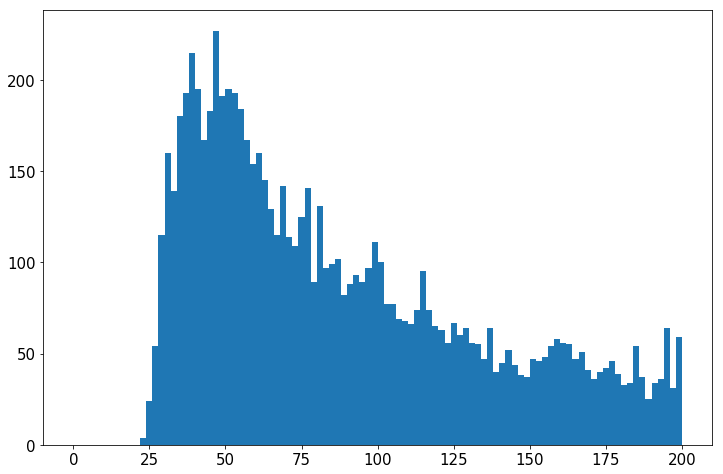

In [53]:
plt.hist(max_charge, bins=100, range=(0, 200));

In [51]:
max_charge.max()

1239.0